In [ ]:
import numpy as np
import tensorflow as tf

# Tensor の生成
t = tf.constant([1., 2., 3.], dtype=tf.float32)
print(t)

try:
    t[1] = 4
except TypeError:
    print("Tensor はイミュータブル (変更不可)")

In [3]:
print(tf.ones([3, 2]))
print()
print(tf.fill([2, 3], 9))

tf.Tensor(
[[1. 1.]
 [1. 1.]
 [1. 1.]], shape=(3, 2), dtype=float32)

tf.Tensor(
[[9 9 9]
 [9 9 9]], shape=(2, 3), dtype=int32)


In [7]:
t = tf.ones(3)
print(t.shape)
print(t[tf.newaxis, :].shape)
print(t[None, :].shape)
print(t[:, tf.newaxis].shape)

t2 = tf.ones([3, 2])
print(t2[:, :, tf.newaxis].shape)
print(t2[..., tf.newaxis].shape)

(3,)
(1, 3)
(1, 3)
(3, 1)
(3, 2, 1)
(3, 2, 1)


In [8]:
v = tf.Variable(1.)
print(v)

v.assign(2.)
print(v)

v.assign_add(3.)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>


In [9]:
def original_function(x, y):
    return tf.nn.relu(tf.matmul(x, y))

# デコレータは関数をラップする関数
function1 = tf.function(original_function)

# こちらの記述方法が一般的
@tf.function
def function2(x, y):
    return tf.nn.relu(tf.matmul(x, y))

print(original_function)
print(function1)
print(function2)

<function original_function at 0x7f8c1fc56ef0>


In [10]:
import timeit


class SimpleModel(tf.keras.Model):
    """実験用のシンプルなモデル"""
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.lstm = tf.keras.layers.LSTM(10)
        self.dense = tf.keras.layers.Dense(32)

    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dense(x)
        return x


inputs = tf.random.normal([100, 20, 5])

# 計算グラフを利用しない場合
eager_model = SimpleModel()

# 計算グラフを利用する場合
graph_model = tf.function(SimpleModel())

print("Eager time: {:.2f} sec".format(timeit.timeit(lambda: eager_model(inputs), number=1000)))
print("Graph time: {:.2f} sec".format(timeit.timeit(lambda: graph_model(inputs), number=1000)))

Eager time: 9.63 sec
Graph time: 1.44 sec


In [11]:
def func(x, y):
    return x ** 2 / 4 + y ** 2


x = tf.Variable([1.0])
y = tf.Variable([2.0])
with tf.GradientTape() as t:
    t.watch([x, y])
    z = func(x, y)

t.gradient(z, [x, y])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>]

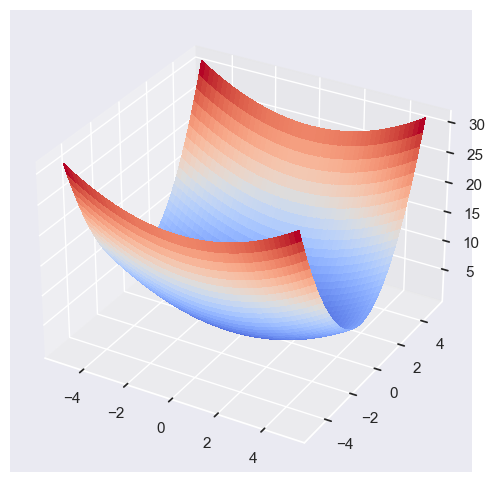

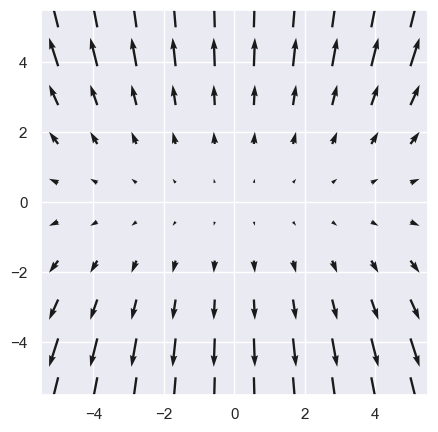

In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

sns.set()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection="3d")

x_coord = y_coord = np.linspace(-5, 5)
XX, YY = np.meshgrid(x_coord, y_coord)
ZZ = func(XX, YY)

# surface plot で 3 次元のデータを可視化
surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# 勾配をベクトルとして可視化
x_coord = y_coord = np.linspace(-5, 5, 10)
XX, YY = np.meshgrid(x_coord, y_coord)

x = tf.Variable(XX)
y = tf.Variable(YY)
with tf.GradientTape() as t:
    z = func(x, y)

# 勾配の算出
x_grads, y_grads = t.gradient(z, [x, y])

fig = plt.figure(figsize=(5, 5))
plt.quiver(XX, YY, x_grads, y_grads)
plt.show()

In [21]:
# 初期値
x = tf.Variable([3.0])
y = tf.Variable([4.0])

# loss は引数がなく, 最小化したい値を返す Callable
loss = lambda: x ** 2 / 4 + y ** 2

epoch = 100
lr = 0.1
losses = []
locs = []

opt = tf.keras.optimizers.SGD(learning_rate=lr)
for _ in range(epoch):
    # minimize では loss の勾配を計算し, variable を更新する.
    opt.minimize(loss, var_list=[x, y])
    losses.append(loss().numpy()[0])
    locs.append([x.numpy()[0], y.numpy()[0]])

print(f"optimized x: {x.numpy()[0]:.2e}")
print(f"optimized y: {y.numpy()[0]:.2e}")

optimized x: 1.78e-02
optimized y: 8.15e-10


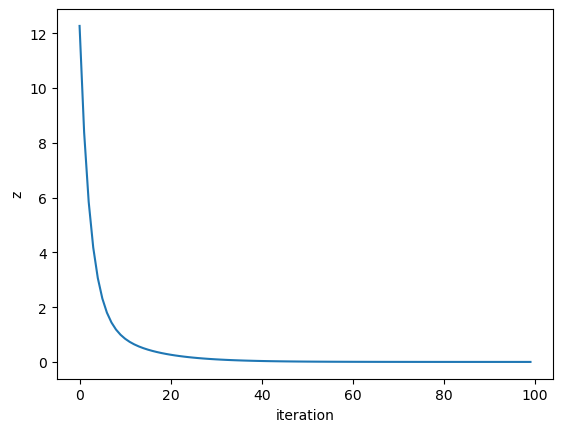

In [23]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('z')
plt.show()

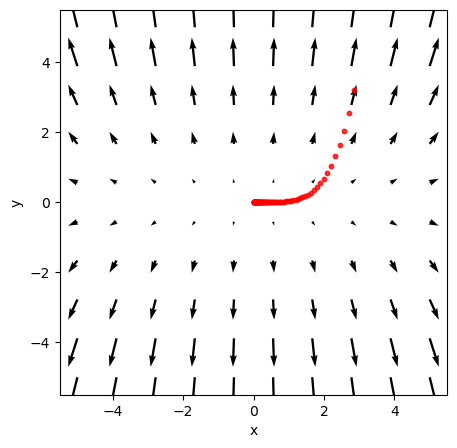

In [29]:
x_coord = y_coord = np.linspace(-5, 5, 10)
XX, YY = np.meshgrid(x_coord, y_coord)
plt.figure(figsize=(5, 5))
plt.quiver(XX, YY, x_grads, y_grads)

locs = np.array(locs)
plt.scatter(locs[:, 0], locs[:, 1], c='r', alpha=0.8, s=10)
plt.xlabel('x')
plt.ylabel('y')

plt.show()

tf.Tensor(-0.9189385, shape=(), dtype=float32)


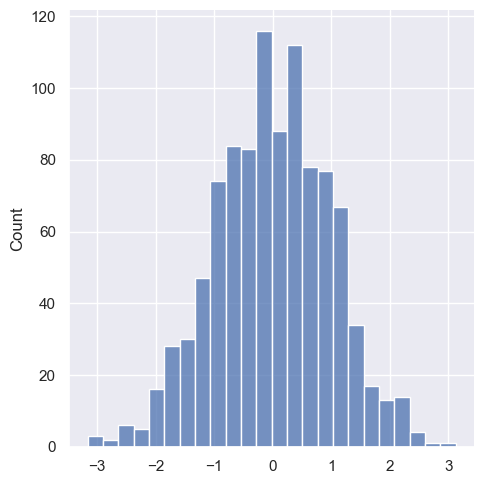

In [32]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# 標準正規分布
normal = tfd.Normal(loc=0., scale=1.)

# 乱数の取得: sample メソッド
samples = normal.sample(1000)
sns.displot(samples)

# 対数確率の算出
print(normal.log_prob(0.))

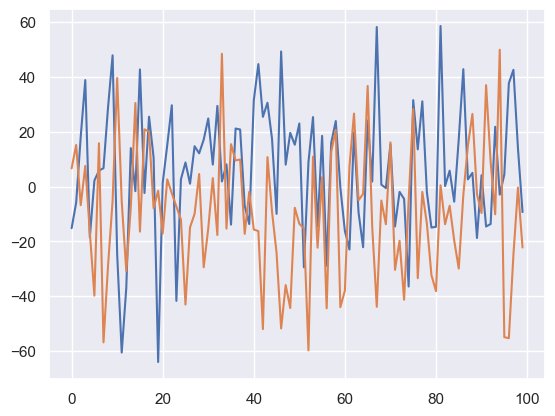

In [36]:
# 線形ガウス状態空間モデル
ndims = 2
step_std = 1.0
noise_std = 5.0

model = tfd.LinearGaussianStateSpaceModel(
    num_timesteps=100,
    transition_matrix=tf.linalg.LinearOperatorIdentity(ndims),
    transition_noise=tfd.MultivariateNormalDiag(
        scale_diag=step_std ** 2 * tf.ones([ndims])
    ),
    observation_matrix=tf.linalg.LinearOperatorIdentity(ndims),
    observation_noise=tfd.MultivariateNormalDiag(
        scale_diag=noise_std ** 2 * tf.ones([ndims])
    ),
    initial_state_prior=tfd.MultivariateNormalDiag(
        scale_diag=tf.ones([ndims])
    )
)

y = model.sample()
for i in range(ndims):
    plt.plot(y[:, i])

plt.show()

In [37]:
exp_bijector = tfb.Exp()

# 変数変換した Distribution
log_normal = exp_bijector(tfd.Normal(0., .5))
print(type(log_normal))

<class 'tensorflow_probability.python.distributions.transformed_distribution.TransformedDistribution'>


/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


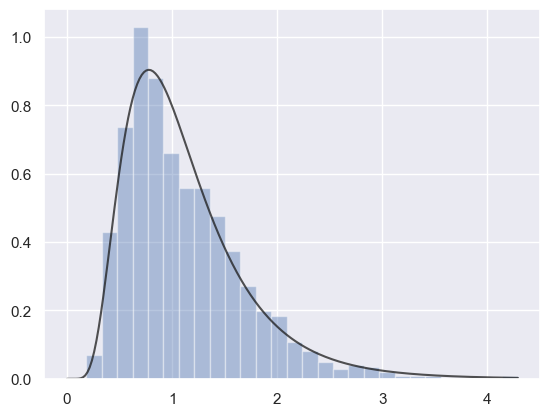

In [39]:
samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c="k", alpha=.75)

In [40]:
normal = tfd.Normal(loc=[-1., 1.], scale=[1., 1.5])
print(normal)

print("shape of sampled Tensor:", normal.sample(10).shape)

tfp.distributions.Normal("Normal", batch_shape=[2], event_shape=[], dtype=float32)
shape of sampled Tensor: (10, 2)


In [41]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
print("Batch_shape:", mvn.batch_shape)
print("Event_shape:", mvn.event_shape)

Batch_shape: ()
Batch_shape: (2,)


In [42]:
normals = tfd.Normal(loc=[-1., 1.], scale=1.)
print("Batch_shape:", normals.batch_shape)
print("Event_shape:", normals.event_shape)

Batch_shape: (2,)
Event_shape: ()


In [43]:
print(mvn.sample().shape)
print(normals.sample().shape)

(2,)
(2,)


In [44]:
print(mvn.log_prob(mvn.sample()))
print(normals.log_prob(normals.sample()))

tf.Tensor(-2.8168757, shape=(), dtype=float32)
tf.Tensor([-1.5678737 -1.2687482], shape=(2,), dtype=float32)


In [45]:
normals = tfd.Normal(loc=[-1., 1.], scale=1.)
print("Batch_shape:", normals.batch_shape)
print("Event_shape:", normals.event_shape)
print()

normals_ind = tfd.Independent(normals, reinterpreted_batch_ndims=1)
print("Batch_shape:", normals_ind.batch_shape)
print("Event_shape:", normals_ind.event_shape)

Batch_shape: (2,)
Event_shape: ()

Batch_shape: ()
Event_shape: (2,)


In [54]:
s = normals.sample()
tf.assert_equal(tf.reduce_sum(normals.log_prob(s)), normals_ind.log_prob(s))

In [55]:
bernoulli = tfd.Bernoulli(probs=0.5)

# 同一の確率分布から複数のサンプルをひとまとめにする
bernoulli_sample = tfd.Sample(bernoulli, sample_shape=10)
print(bernoulli_sample)

tfp.distributions.Sample("SampleBernoulli", batch_shape=[], event_shape=[10], dtype=int32)


In [57]:
s = bernoulli_sample.sample()
print("shape of single sample:", s.shape)

# 複数のサンプルについて, 対数確率の和が算出される
print(bernoulli_sample.log_prob(s))

shape of single sample: (10,)
tf.Tensor(-6.931472, shape=(), dtype=float32)


### 2.6.4 簡単なモデリングの例

$$
\begin{align*}
    \theta &\sim \text{Unif}(\theta | 0, 1) \\
    y_n | \theta &\sim \text{Bern}(y_n | \theta), \ n = 1, \dots, N
\end{align*}
$$

In [79]:
# コインを10回投げ、6回表が出たとする。
N = 10
x = 6

# JointDsitributionを用いて同時分布を定義
Root = tfd.JointDistributionCoroutine.Root
def model():
    # 事前分布はRootで囲う
    p = yield Root(tfd.Uniform(0, 1))
    x = yield tfd.Binomial(total_count=N, probs=p)

# 同時分布を表すDistributionオブジェクト
binom_model = tfd.JointDistributionCoroutine(model)

# 参考：普通のDistributionと同じように、sampleやlog_probメソッドを利用可能
p_s, x_s = binom_model.sample()
binom_model.log_prob(p_s, x_s)

# 観測データ（表が出た回数）を与え、パラメータを引数として対数事後確率を算出する関数を定義する。
def beta_binom_logp(p):
    return binom_model.log_prob(p, x)


# 参考：JointDistributionを用いない場合、以下のように記述することもできる。
# def beta_binom_logp(p):
#   prior = tfd.Uniform(0, 1)
#   likelihood = tfd.Binomial(total_count=N, probs=p)
#   return prior.log_prob(p) + likelihood.log_prob(x)

In [80]:
num_results = 6000
num_burnin_steps = 2000

# tf.function でデコレートすることで, 計算グラフがコンパイルされ, 高速に実行される
@tf.function(autograph=False, experimental_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        # パラメータの初期値
        current_state=[
            # 複数チェーンでサンプリングしたい場合, 初期値のリストを与える
            tf.constant([0.5, 0.5, 0.5], name="init_p")
        ],
        # ハミルトニアン・モンテカルロ法を用いる.
        # step_size というハイパーパラメータの調整が必要になるが,
        # SimpleStepSizeAdaptation でラップすることで, 推論の過程で自動的に調整してくれる.
        # 今回のパラメータは [0, 1] の範囲に制約されているため, TransformedTransitionKernel を利用し,
        # tfb.Sigmoid を適用することで, 制約を満たすようにする.
        kernel=tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                tfp.mcmc.HamiltonianMonteCarlo(
                    # 先ほど定義した対数事後確率
                    target_log_prob_fn=beta_binom_logp,
                    step_size=0.1,
                    num_leapfrog_steps=5
                ),
                bijector=[tfb.Sigmoid()]
            ),
            num_adaptation_steps=int(num_burnin_steps * 0.8)
        ),
        seed=1,
    )

# states は事後分布からのサンプル, kernel_results はサンプルの受容・棄却の履歴など
# MCMC の各ステップの情報が含まれる
states, kernel_results = do_sampling()

# 提案の受容率
acceptance_rates = kernel_results.inner_results.inner_results.is_accepted.numpy().mean(axis=0)
print("Acceptance rate: {0:.1%} {1:.1%} {2:.1%}".format(*acceptance_rates))

/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 71.1% 71.1% 72.2%


In [81]:
import arviz as az

def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが１つだと明示するためaxisを追加
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        # axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v in zip(var_name, states)}
    # from_tfpもあるが、実行するとeager_executionがオフにされてしまうなど現状使いづらいので、from_dictを用いている
    return az.from_dict(trace)

In [82]:
trace = format_trace(states, var_name=['p'], chain_dim=1)
s = az.summary(trace)

display(s)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.583,0.135,0.336,0.833,0.001,0.001,19968.0,5273.0,1.0


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

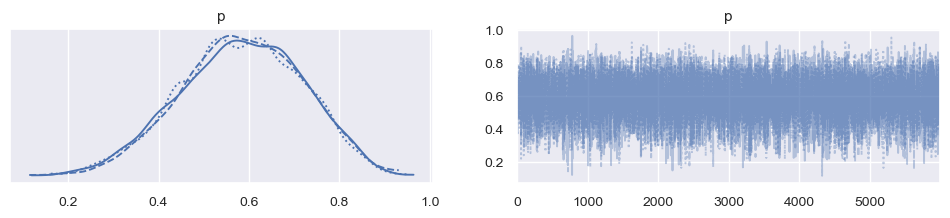

In [83]:
az.plot_trace(trace)

true posterior mean: 0.583


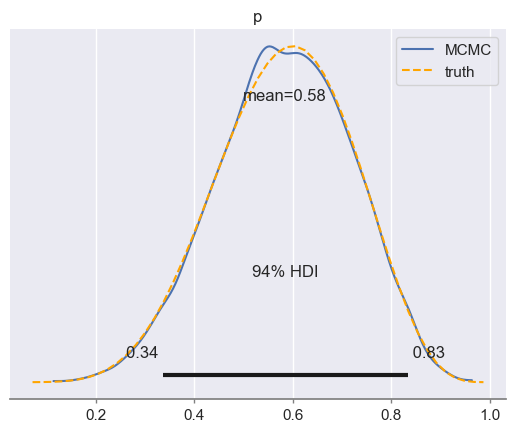

In [84]:
true_posterior = tfd.Beta(1 + x, 1 + N - x)

ax = az.plot_posterior(trace)
ax.lines[0].set_label('MCMC')

xx = np.linspace(*ax.get_xlim())
ax.plot(xx, true_posterior.prob(xx), ls='--', color='orange', label='truth')
ax.legend()

print('true posterior mean: {:.3f}'.format(true_posterior.mean()))